In [17]:
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
%cd '/content/drive/My Drive/RL/amalearn'

/content/drive/My Drive/RL/amalearn


In [19]:
!pwd

/content/drive/My Drive/RL/amalearn


In [20]:
!pip install -e .

Obtaining file:///content/drive/My%20Drive/RL/amalearn
  Attempting uninstall: amalearn
    Found existing installation: amalearn 0.1
    Can't uninstall 'amalearn'. No files were found to uninstall.
  Running setup.py develop for amalearn


In [21]:
import numpy as np
import matplotlib.pyplot as plt
import math
from amalearn.agent import AgentBase
import csv
import pandas as pd
from numpy import exp

##REWARD

In [22]:
from amalearn.reward import RewardBase
import numpy as np

class GaussianReward(RewardBase):
    def __init__(self, mean, std):
        super(GaussianReward, self).__init__()
        self.mean = mean
        self.std = std

    def get_reward(self):
        return np.random.normal(loc=self.mean, scale=self.std)


class UniformReward(RewardBase):
    def __init__(self, low, high):
      super(UniformReward, self).__init__()
      self.low = low
      self.high = high

    def get_reward(self):
        return np.random.uniform(low=self.low, high=self.high, size=None)


class BetaReward(RewardBase):
    def __init__(self, a, b):
      super(BetaReward, self).__init__()
      self.a = a
      self.b = b

    def get_reward(self):
        return np.random.beta(a=self.a, b=self.b, size=None)

In [23]:
def SelectPack(volumes, prices):
  random_number = np.random.random_sample()
  
  
  if random_number >= 0.33:
    x = BetaReward(2,5).get_reward()
    volumes_beta = []
    for i in range(len(volumes)):
      volumes_beta.append(volumes[i] * x)
    selected_pack = np.argmax(volumes_beta) 
  else:
    x = BetaReward(3,2.5).get_reward()
    volumes_prices_beta = np.divide(volumes, prices) * x
    selected_pack = np.argmin(volumes_prices_beta)
  return selected_pack

In [24]:
class Pack:
    def __init__(self, p, v):
        
        self.price = p
        self.volume = v

    def get_price(self):
      return self.price
    def get_volume(self):
      return self.volume


##Epsilon Greedy

In [25]:
class EpsilonGreedyAgent(AgentBase):
    def __init__(self, id, environment):
        super(EpsilonGreedyAgent, self).__init__(id, environment)
        
        self.counts = [0 for col in range(2)]
        self.values = [0.0 for col in range(2)]
        self.epsilon = 0.1

       
  
    def take_action(self) -> (object, float, bool, object , np.ndarray ):
      available_actions = self.environment.available_actions()

      random_number = np.random.random_sample()
      if random_number >= self.epsilon:
        action = np.argmax(self.values)
      else:
        action = np.random.randint(available_actions)

      #plan1
      pack1 = Pack(21, 6)
      pack2 = Pack(35, 12)
      #plan2
      pack3 = Pack(12, 3)
      pack4 = Pack(22, 8)

      volumes_plan1 = np.array([pack1.get_volume(), pack2.get_volume()])
      prices_plan1 = np.array([pack1.get_price(), pack2.get_price()])
      volumes_plan2 = np.array([pack3.get_volume(), pack4.get_volume()])
      prices_plan2 = np.array([pack3.get_price(), pack4.get_price()])

      if action == 0:
        selected_pack = SelectPack(volumes_plan1, prices_plan1)
      else:
        selected_pack = SelectPack(volumes_plan2, prices_plan2)
      # print(selected_pack)
      
      obs, r, d, i = self.environment.step(selected_pack)


      # if r > 0 :
      #   r = math.pow(r, self.alpha)
      # else:
      #   r = -self.gamma*math.pow(r, self.beta)       
      
      # self.counts[action] = self.counts[action] + 1
      # n = self.counts[action]
      # value = self.values[action]
      # new_value = ((n-1) / float(n)) * value + (1 / float(n)) * r
      # self.values[action] = new_value
      # print(self.values)
      return obs, r, d, i, action, selected_pack
    
    def set_epsilon(self):
      self.epsilon += 0.001

  


##Environment

In [26]:
import gym
from amalearn.environment import EnvironmentBase

class MyEnvironment(EnvironmentBase):
    def __init__(self, rewards, episode_max_length, id, container=None):
        state_space = gym.spaces.Discrete(1)
        action_space = gym.spaces.Discrete(len(rewards))

        super(MyEnvironment, self).__init__(action_space, state_space, id, container)
        self.arms_rewards = rewards
        self.episode_max_length = episode_max_length
        self.state = {
            'length': 0,
            'last_action': None
        }

    def calculate_reward(self, action):
        return self.arms_rewards[action]

    def terminated(self):
        return self.state['length'] >= self.episode_max_length

    def observe(self):
        return {}

    def available_actions(self):
        return self.action_space.n

    def next_state(self, action):
        self.state['length'] += 1
        self.state['last_action'] = action

    def reset(self):
        self.state['length'] = 0
        self.state['last_action'] = None

    def render(self, mode='human'):
        print('{}:\taction={}'.format(self.state['length'], self.state['last_action']))

    def close(self):
        return
        

##Rewards

In [27]:
rewards = []
#plan1
pack1 = Pack(21, 6)
pack2 = Pack(35, 12)
#plan2
pack3 = Pack(12, 3)
pack4 = Pack(22, 8)

prices = np.array([[pack1.get_price(), pack2.get_price()], [pack3.get_price(), pack4.get_price()]])
volumes = np.array([[pack1.get_volume(), pack2.get_volume()], [pack3.get_volume(), pack4.get_volume()]])
remain_volume = 1-GaussianReward(0.61,0.05).get_reward()
rewards = prices + (prices * remain_volume)

print(rewards)

[[30.57493604 50.95822673]
 [17.47139202 32.03088537]]


In [28]:
env = MyEnvironment(rewards=rewards, episode_max_length = 1000, id = '1')
agent1 = EpsilonGreedyAgent('1', env)

##EPSILONGREEDY_RUN

0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:65: RuntimeWarning: divide by zero encountered in double_scalars


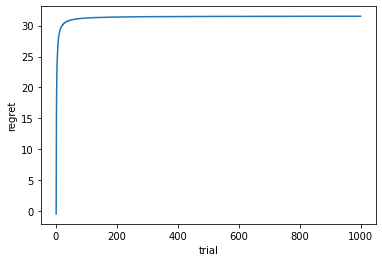

In [29]:
plt.figure()
r1 = r2 = 0
count1 = count2 = 0
for k in range(1,10000):
  observation, reward, done, info, action, selected_pack = agent1.take_action()
  if (action == 0) and (selected_pack == 0):
    r1 += reward[0]
    count1 +=1
  elif (action == 0) and (selected_pack == 1):
    r1 += reward[1]
    count1 +=1
  elif (action == 1) and (selected_pack == 0):
    r2 += reward[0]
    count2 +=1
  else:
    r2 += reward[1]
    count2 +=1

average_action1 = r1/count1
if count2 == 0:
  average_action2 = 0
else:
  average_action2 = r2/count2

if average_action1 > average_action2:
  optimal_action = 0
  optimal_average = average_action1
else:
  optimal_action = 1
  optimal_average = average_action2

print(optimal_action)
for i in range(10):
  agent1.epsilon= 0.1
  count = [0 for col in range(2)]
  values = [0.0 for col in range(2)]
  rewards = []
  selected_action = []
  REGRET = []
  for j in range(1,1001):
    if j % 100 == 0:
      # print(j)
      agent1.epsilon += 0.05
      # print(agent1.epsilon)
    observation, reward, done, info, action, selected_pack = agent1.take_action()
    
    count[action] +=1
    if (action == 0) and (selected_pack == 0): 
      values[action] = reward[0] * (1/count[action]) + ((count[action]-1)/count[action])*values[action]
      rewards.append(reward[0])
    elif (action == 0) and (selected_pack == 1): 
      values[action] = reward[1] * (1/count[action]) + ((count[action]-1)/count[action])*values[action]
      rewards.append(reward[1])
    
    elif (action == 1) and (selected_pack == 0): 
      values[action] = reward[0] * (1/count[action]) + ((count[action]-1)/count[action])*values[action]
      rewards.append(reward[0])
    else:
      values[action] = reward[1] * (1/count[action]) + ((count[action]-1)/count[action])*values[action]
      rewards.append(reward[1])
    
    selected_action.append(action)
  
  for k in range(len(selected_action)):
    regret = (optimal_average - rewards[k]/k)
    REGRET.append(regret)

plt.plot(REGRET)
plt.xlabel("trial")
plt.ylabel("regret")
plt.show()